# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [ ]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** Благодаря МГК мы снижаем размерность данных, что позволяет оставить наиболее важные признаки и уменьшить сложность вычислений.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

np.random.seed(52)
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [ ]:
from sklearn.metrics import accuracy_score
import time

In [ ]:
np.random.seed(52)
start_time = time.time()
pipeline.fit(x_train, y_train)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
pipeline.predict(x_train)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

accuracy = accuracy_score(y_train, pipeline.predict(x_train))
print(f"Train Accuracy: {accuracy:.4f}")

final_accuracy = accuracy_score(y_test, pipeline.predict(x_test))
print(f"Test Accuracy: {final_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Время выполнения fit: 81.0288 секунд
Время выполнения predict: 8.7886 секунд
Train Accuracy: 0.8883
Test Accuracy: 0.8623


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
np.random.seed(52)
indexes = np.random.choice(len(y_train), size=(len(y_train) // 20), replace=False)
x_train_subset = x_train[indexes]
y_train_subset = y_train[indexes]

indexes = np.random.choice(len(y_test), size=(len(y_test) // 20), replace=False)
x_test_subset = x_test[indexes]
y_test_subset = y_test[indexes]

In [ ]:
np.random.seed(52)
log_reg = LogisticRegression()

start_time = time.time()
log_reg.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = log_reg.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Logistic Regression on train: {accuracy_score(y_train_subset, log_reg.predict(x_train_subset))}')
print(f'Accuracy with Logistic Regression on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 2.6692 секунд
Время выполнения predict: 0.0027 секунд
Accuracy with Logistic Regression on train: 0.9673333333333334
Accuracy with Logistic Regression on test: 0.786


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
np.random.seed(52)

pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_subset)
x_test_pca = pca.transform(x_test_subset)

In [ ]:
np.random.seed(52)

log_reg= LogisticRegression()

start_time = time.time()
log_reg.fit(x_train_pca, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = log_reg.predict(x_test_pca)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Logistic Regression + PCA on train: {accuracy_score(y_train_subset, log_reg.predict(x_train_pca))}')
print(f'Accuracy with Logistic Regression + PCA on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 0.4190 секунд
Время выполнения predict: 0.0020 секунд
Accuracy with Logistic Regression + PCA on train: 0.908
Accuracy with Logistic Regression + PCA on test: 0.774


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
np.random.seed(52)
pipeline_no_PCA = RFFPipeline(n_features=1000, new_dim=50, use_PCA = False, feature_creator_class=RandomFeatureCreator)
pipeline_no_PCA.fit(x_train_subset, y_train_subset)

start_time = time.time()
pipeline_no_PCA.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_no_PCA.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f"Accuracy with Logistic Regression + RFF on train: {accuracy_score(y_train_subset, pipeline_no_PCA.predict(x_train_subset))}")
print(f"Accuracy with Logistic Regression + RFF on test: {accuracy_score(y_test_subset, preds)}")

Время выполнения fit: 2.0495 секунд
Время выполнения predict: 0.1501 секунд
Accuracy with Logistic Regression + RFF on train: 1.0
Accuracy with Logistic Regression + RFF on test: 0.118


In [ ]:
np.random.seed(52)
pipeline_PCA = RFFPipeline(n_features=1000, new_dim=50, use_PCA = True, feature_creator_class=RandomFeatureCreator)
pipeline_PCA.fit(x_train_subset, y_train_subset)

start_time = time.time()
pipeline_PCA.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_PCA.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f"Accuracy with Logistic Regression + RFF + PCA on train: {accuracy_score(y_train_subset, pipeline_PCA.predict(x_train_subset))}")
print(f"Accuracy with Logistic Regression + RFF + PCA on test: {accuracy_score(y_test_subset, preds)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Время выполнения fit: 13.2637 секунд
Время выполнения predict: 0.1241 секунд
Accuracy with Logistic Regression + RFF + PCA on train: 0.9963333333333333
Accuracy with Logistic Regression + RFF + PCA on test: 0.8


In [ ]:
np.random.seed(52)
svm_linear = SVC(kernel="linear")

start_time = time.time()
svm_linear.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = svm_linear.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Linear SVM on train: {accuracy_score(y_train_subset, svm_linear.predict(x_train_subset))}')
print(f'Accuracy with Linear SVM on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 0.9624 секунд
Время выполнения predict: 0.2207 секунд
Accuracy with Linear SVM on train: 1.0
Accuracy with Linear SVM on test: 0.806


In [ ]:
np.random.seed(52)
pipeline_SVC_no_PCA = RFFPipeline(n_features=1000, new_dim=50, use_PCA = False, feature_creator_class=RandomFeatureCreator, classifier_class = SVC)

start_time = time.time()
pipeline_SVC_no_PCA.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_SVC_no_PCA.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Linear SVM + RFF on train: {accuracy_score(y_train_subset, pipeline_SVC_no_PCA.predict(x_train_subset))}')
print(f'Accuracy with Linear SVM + RFF on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 6.7918 секунд
Время выполнения predict: 3.0343 секунд
Accuracy with Linear SVM + RFF on train: 0.9996666666666667
Accuracy with Linear SVM + RFF on test: 0.118


In [ ]:
np.random.seed(52)
pipeline_SVC = RFFPipeline(n_features=1000, new_dim=50, use_PCA = True, feature_creator_class=RandomFeatureCreator, classifier_class = SVC)

start_time = time.time()
pipeline_SVC.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_SVC.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Linear SVM + RFF + PCA on train: {accuracy_score(y_train_subset, pipeline_SVC.predict(x_train_subset))}')
print(f'Accuracy with Linear SVM + RFF + PCA on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 2.9729 секунд
Время выполнения predict: 1.5215 секунд
Accuracy with Linear SVM + RFF + PCA on train: 0.8636666666666667
Accuracy with Linear SVM + RFF + PCA on test: 0.832


In [ ]:
np.random.seed(52)
svm_kernel = SVC(kernel="rbf")

start_time = time.time()
svm_kernel.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = svm_kernel.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Kernel SVM on train: {accuracy_score(y_train_subset, svm_kernel.predict(x_train_subset))}')
print(f'Accuracy with Kernel SVM on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 1.2533 секунд
Время выполнения predict: 1.0313 секунд
Accuracy with Kernel SVM on train: 0.889
Accuracy with Kernel SVM on test: 0.828


In [ ]:
np.random.seed(52)
svm_kernel = SVC(kernel="rbf")

start_time = time.time()
svm_kernel.fit(x_train_pca, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = svm_kernel.predict(x_test_pca)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Kernel SVM + PCA on train: {accuracy_score(y_train_subset, svm_kernel.predict(x_train_pca))}')
print(f'Accuracy with Kernel SVM + PCA on test: {accuracy_score(y_test_subset, preds)}')

Время выполнения fit: 0.3991 секунд
Время выполнения predict: 0.1059 секунд
Accuracy with Kernel SVM + PCA on train: 0.8876666666666667
Accuracy with Kernel SVM + PCA on test: 0.826


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(52)

lgbm = LGBMClassifier(n_estimators=100)

start_time = time.time()
lgbm.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = lgbm.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with LGBM on train: {accuracy_score(y_train_subset, lgbm.predict(x_train_subset))}')
print(f'Accuracy with LGBM on test: {accuracy_score(y_test_subset, preds)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142251
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 772
[LightGBM] [Info] Start training from score -2.326195
[LightGBM] [Info] Start training from score -2.228715
[LightGBM] [Info] Start training from score -2.286056
[LightGBM] [Info] Start training from score -2.305924
[LightGBM] [Info] Start training from score -2.279520
[LightGBM] [Info] Start training from score -2.295941
[LightGBM] [Info] Start training from score -2.407946
[LightGBM] [Info] Start training from score -2.309274
[LightGBM] [Info] Start training from score -2.260164
[LightGBM] [Info] Start training from score -2.336487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [ ]:
np.random.seed(52)

lgbm = LGBMClassifier(n_estimators=100)

start_time = time.time()
lgbm.fit(x_train_pca, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
lgbm.predict(x_test_pca)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with LGBM + PCA on train: {accuracy_score(y_train_subset, lgbm.predict(x_train_pca))}')
print(f'Accuracy with LGBM + PCA on test: {accuracy_score(y_test_subset, lgbm.predict(x_test_pca))}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 100
[LightGBM] [Info] Start training from score -2.326195
[LightGBM] [Info] Start training from score -2.228715
[LightGBM] [Info] Start training from score -2.286056
[LightGBM] [Info] Start training from score -2.305924
[LightGBM] [Info] Start training from score -2.279520
[LightGBM] [Info] Start training from score -2.295941
[LightGBM] [Info] Start training from score -2.407946
[LightGBM] [Info] Start training from score -2.309274
[LightGBM] [Info] Start training from score -2.260164
[LightGBM] [Info] Start training from score -2.336487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

С точки зрения качества на тестовой выборке SVM + RFF + PCA показала себя лучше всех. При этом надо учесть тот факт, что модели обучались на 1/20 всей обучающей выборки, так что, наверное, бустинг мог бы перебить нашу модель. При этом очевидно, что PCA ухушает качество всех моделей, кроме тех, в которых используется RFF.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [ ]:
np.random.seed(52)
pipeline_no_PCA = RFFPipeline(n_features=1000, new_dim=50, use_PCA = False, feature_creator_class=RandomFeatureCreator)
pipeline_no_PCA.fit(x_train, y_train)

accuracy = accuracy_score(y_train, pipeline_no_PCA.predict(x_train))
print(f"Train Accuracy: {accuracy:.4f}")

final_accuracy = accuracy_score(y_test, pipeline_no_PCA.predict(x_test))
print(f"Test Accuracy: {final_accuracy:.4f}")

Train Accuracy: 0.1890
Test Accuracy: 0.1067


Как можно заметить, в первом задании у нас по условию используется PCA и там мы получили accuracy 0.86. Тут мы специально выключили использование PCA и получили accuracy 0.11. Вывод: PCA помогает.

In [ ]:
np.random.seed(52)
s = []
for num in [100, 500, 1000, 2000, 4000]:
    pipeline_for_test = RFFPipeline(n_features=num, new_dim=50, use_PCA = True, feature_creator_class=RandomFeatureCreator)
    pipeline_for_test.fit(x_train, y_train)

    accuracy = accuracy_score(y_train, pipeline_for_test.predict(x_train))
    print(f"Train Accuracy: {accuracy:.4f}")

    final_accuracy = accuracy_score(y_test, pipeline_for_test.predict(x_test))
    print(f"Test Accuracy: {final_accuracy:.4f}")
    s.append(final_accuracy)

Train Accuracy: 0.8204
Test Accuracy: 0.8067
Train Accuracy: 0.8782
Test Accuracy: 0.8549
Train Accuracy: 0.8875
Test Accuracy: 0.8596
Train Accuracy: 0.8947
Test Accuracy: 0.8655
Train Accuracy: 0.8983
Test Accuracy: 0.8690


In [ ]:
import matplotlib.pyplot as plt

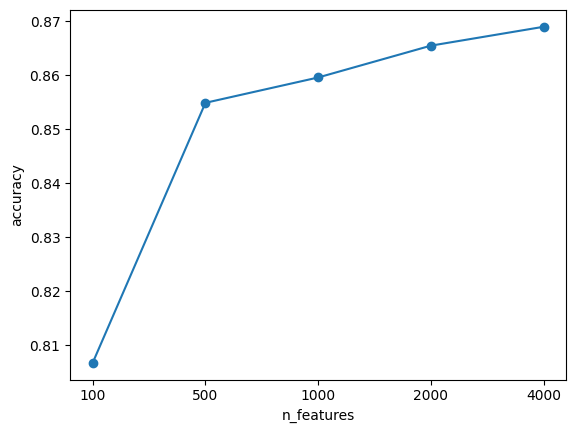

In [ ]:
plt.plot(['100', '500', '1000', '2000', '4000'], s, marker='o')

plt.xlabel('n_features')
plt.ylabel('accuracy')

plt.show()

Из графика очевидно, что с повышением n_features выходит на плато.

In [ ]:
np.random.seed(52)
pipeline_SVC = RFFPipeline(n_features=1000, new_dim=50, use_PCA = True, feature_creator_class=RandomFeatureCreator, classifier_class = SVC)

start_time = time.time()
pipeline_SVC.fit(x_train_subset, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_SVC.predict(x_test_subset)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

final_accuracy = accuracy_score(y_test_subset, preds)
print(f"Test Accuracy: {final_accuracy:.4f}")

Время выполнения fit: 9.3339 секунд
Время выполнения predict: 3.2970 секунд
Test Accuracy: 0.8320


SVM показал себя лучше обычной модели с RFF, но при этом очень-очень долго обучался и делал предикты.

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [ ]:
from homework_practice_08_rff import OrthogonalRandomFeatureCreator

In [ ]:
np.random.seed(52)
pipeline_orf = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)

start_time = time.time()
pipeline_orf.fit(x_train, y_train)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = pipeline_orf.predict(x_test)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

accuracy = accuracy_score(y_train, pipeline_orf.predict(x_train))
print(f"Train Accuracy: {accuracy:.4f}")

final_accuracy = accuracy_score(y_test, preds)
print(f"Test Accuracy: {final_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Время выполнения fit: 91.7922 секунд
Время выполнения predict: 1.4748 секунд
Train Accuracy: 0.8891
Test Accuracy: 0.8634


Можно сказать, что ORF показал себя немного лучше, чем RFF по целевой метрике, но при этом он всё ещё хуже RFF + SVM.

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___ https://arxiv.org/pdf/2212.07658

___описание идеи:___ В данной статье авторы используют полиномиальные ядра. Главным отличием от RFF является тот факт, что RFF может работать только с положительно определёнными и симметричными ядрами, а полиномиальные ядра таковыми не являются. (вообще я взял уже готовую реализацию из scikit-learn)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
np.random.seed(52)

poly_features = PolynomialFeatures(degree=(1, 2))
x_train_poly = poly_features.fit_transform(x_train_subset)
x_test_poly = poly_features.transform(x_test_subset)

In [ ]:
np.random.seed(52)

log_reg_poly = LogisticRegression()

start_time = time.time()
log_reg_poly.fit(x_train_poly, y_train_subset)
end_time = time.time()
print(f"Время выполнения fit: {end_time - start_time:.4f} секунд")

start_time = time.time()
preds = log_reg_poly.predict(x_test_poly)
end_time = time.time()
print(f"Время выполнения predict: {end_time - start_time:.4f} секунд")

print(f'Accuracy with Kernel SVM on train: {accuracy_score(y_train_subset, log_reg_poly.predict(x_train_poly))}')
print(f'Accuracy with Kernel SVM on test: {accuracy_score(y_test_subset, preds)}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Время выполнения fit: 678.1874 секунд
Время выполнения predict: 0.5282 секунд
Accuracy with Kernel SVM on train: 1.0
Accuracy with Kernel SVM on test: 0.81


В данном задании применяется уже обычная логистическая регрессия дополнительными полиномиальными признаками. Как можно заметить, она похуже, чем наш пайплайн с RFF + PCA. Возможно, в данном случае тоже нужно использовать PCA, но алгоритм слишком долго работает, поэтому не будем.

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\nabla Q(w) = \Phi \Phi^T(\Phi \Phi^Tw - y) + \lambda\Phi \Phi^Tw
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [ ]:
from homework_practice_08_kernel_regression import KernelRidgeRegression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing

In [ ]:
np.random.seed(52)

california = fetch_california_housing()

indexes = np.random.choice(len(california.target), size=1000, replace=False)
X = california.data[indexes]
y = california.target[indexes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Генерация данных
np.random.seed(42)

# Ядровая Ridge-регрессия
kr = KernelRidgeRegression(lr=0.01, regularization=1.0, max_iter=2000)
a = kr.fit(X_train, y_train)
y_pred_kr = kr.predict(X_test)
mse_kr = mean_squared_error(y_test, y_pred_kr)

# RFF Ridge-регрессия
pipeline_ridge = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=Ridge)
b = pipeline_ridge.fit(X_train, y_train)
y_pred_rff = pipeline_ridge.predict(X_test)
mse_rff = mean_squared_error(y_test, y_pred_rff)

print(f"MSE Kernel Ridge: {mse_kr:.4f}")
print(f"MSE RFF Ridge: {mse_rff:.4f}")

MSE Kernel Ridge: 5.9410
MSE RFF Ridge: 0.7797


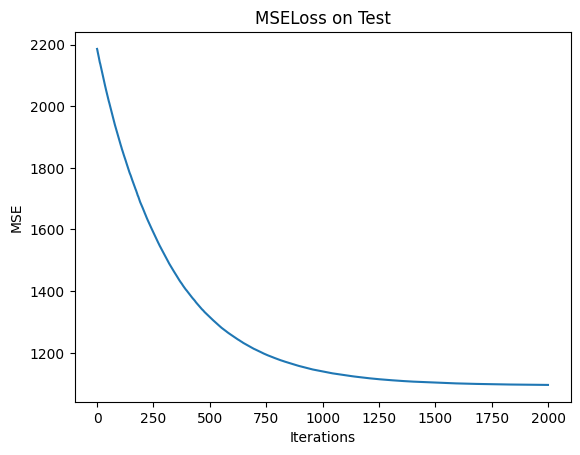

In [ ]:
plt.plot(a)
plt.title('MSELoss on Test')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.show()

Правды ради, я без понятия, почему такая большая разница в лоссе двух моделей, но скорее всего я неверно адаптировал RFFPipeline.